In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve,precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [311]:
train= pd.read_csv('train.csv')

In [312]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [313]:
train['Driving_License'] = train['Driving_License'].astype('object')
train['Region_Code'] = train['Region_Code'].astype('object')
train['Previously_Insured'] = train['Previously_Insured'].astype('object')
train['Policy_Sales_Channel']= train['Policy_Sales_Channel'].astype('object')
train['Response'] = train['Response'].astype('object')

In [314]:
train['Region_Code'] = train['Region_Code'].apply(lambda x: 'Other Region'
                                                  if x in (39,10,21,2,13,7,12,9,27,32,43,17,26,25,24,38,0,16,23,31,20,49,4,34,19,22,40,44,5,1,42,52,51)
                                                  else x)
train['Policy_Sales_Channel'] = train['Policy_Sales_Channel'].apply(lambda x: 'Other_sales_channels'
                                                  if x not in (152,26,124,160,156)
                                                  else x)
train=train.drop('id',axis=1)

In [315]:
train['Region_Code'] = train['Region_Code'].apply(lambda x: 'Medium_resp_Region'
                                                  if x in (8,11,14,33,45,46,47,48)
                                                  else x)
train['Region_Code'] = train['Region_Code'].apply(lambda x: 'High_resp_Region'
                                                  if x in (3,18,28,29,35,41)
                                                  else x)
train['Region_Code'] = train['Region_Code'].apply(lambda x: 'low_resp_Region'
                                                  if x in (6,15,30,36,37,50,'Other Region')
                                                  else x)

In [316]:
from sklearn.preprocessing import PowerTransformer
for i in train.select_dtypes(np.number):
    pt = PowerTransformer()
    train[i] = pt.fit_transform(train[[i]])

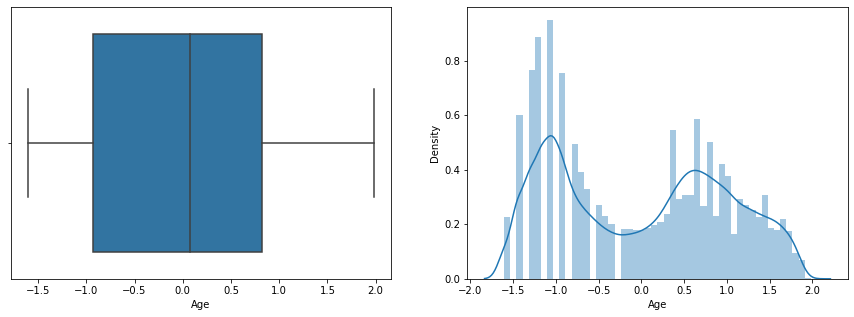

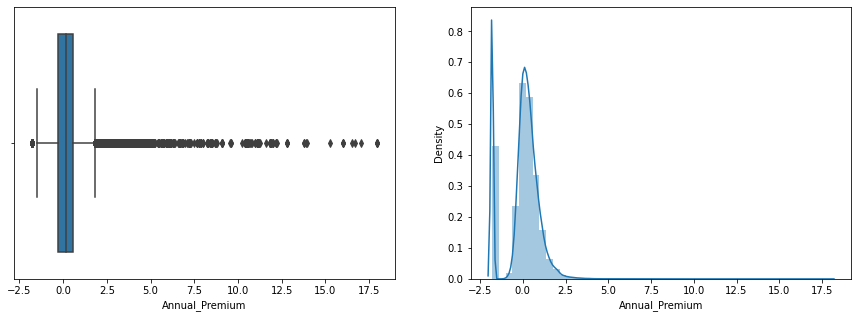

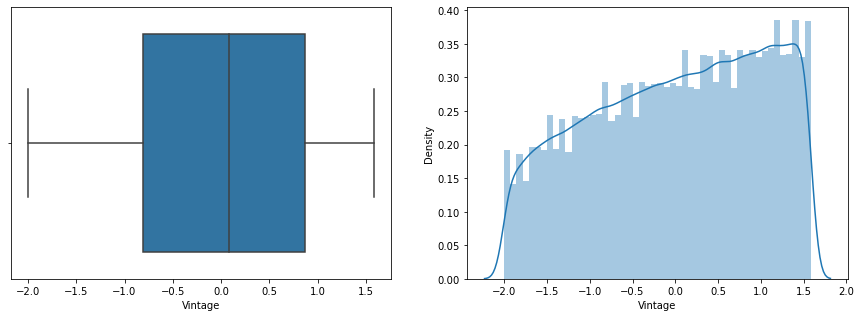

In [317]:
for i in train.select_dtypes(np.number):
    fig , ax = plt.subplots(1,2,figsize=(15,5))
    sns.boxplot(train[i] , ax=ax[0])
    sns.distplot(train[i] , ax=ax[1])
    plt.show()

In [318]:
train= train.drop('Vintage',axis=1)
train['Gender']= train['Gender'].map({'Female':0,'Male':1})
train['Vehicle_Damage']= train['Vehicle_Damage'].map({'No':0,'Yes':1})
train['Policy_Sales_Channel']= train['Policy_Sales_Channel'].map({'Other_sales_channels':0,156:1,160:2,124:3
                                                                  ,26:4,152:5})
train['Region_Code']= train['Region_Code'].map({'low_resp_Region':0,'Medium_resp_Region':1,'High_resp_Region':2})

In [319]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

### Model building with balanced data

In [320]:
y= train['Response']
y= y.astype('int')
x= train.drop('Response',axis=1)
X = pd.get_dummies(x,drop_first=True)

In [321]:
X.columns

Index(['Gender', 'Age', 'Region_Code', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Driving_License_1', 'Previously_Insured_1',
       'Vehicle_Age_< 1 Year', 'Vehicle_Age_> 2 Years'],
      dtype='object')

In [322]:
X= X.rename(columns={'Vehicle_Age_< 1 Year':'New_vehicles','Vehicle_Age_> 2 Years':'Old_vehicles'})

In [323]:
y.value_counts()

0    334399
1     46710
Name: Response, dtype: int64

In [324]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [325]:
Smk= SMOTETomek (sampling_strategy=30/70)
Xnew,ynew=Smk.fit_resample(x_train,y_train)

In [326]:
Xnew.shape , ynew.shape, x_test.shape , y_test.shape

((306207, 10), (306207,), (114333, 10), (114333,))

In [327]:
ynew.value_counts()

0    220019
1     86188
Name: Response, dtype: int64

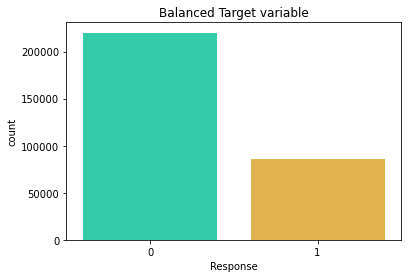

In [328]:
plt.rcParams['figure.figsize']= 6,4
sns.countplot(ynew,palette='turbo')
plt.title('Balanced Target variable')
plt.show()

### Decision tree model

In [235]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report

In [329]:
dt= DecisionTreeClassifier()
dt= dt.fit(Xnew,ynew)
y_pred_dt = dt.predict(x_test)
print(classification_report(y_test, y_pred_dt))
print('Training Accuracy', dt.score(Xnew,ynew),'\tTesting Accuracy', dt.score(x_test,y_test))
print('Training Precision', precision_score(ynew,dt.predict(Xnew)),'\tTesting Precision',precision_score(y_test,y_pred_dt))
print('Training Recall', recall_score(ynew,dt.predict(Xnew)),'\tTesting Recall',recall_score(y_test,y_pred_dt))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89    100195
           1       0.30      0.38      0.34     14138

    accuracy                           0.81    114333
   macro avg       0.60      0.63      0.61    114333
weighted avg       0.83      0.81      0.82    114333

Training Accuracy 0.9667806418533867 	Testing Accuracy 0.812722486071388
Training Precision 0.9398972246012823 	Testing Precision 0.2988162407345945
Training Recall 0.942230937021395 	Testing Recall 0.38209081906917525


In [67]:
from sklearn.metrics import precision_score
tuned_paramaters = [{'criterion': ['entropy', 'gini'],
                     'max_depth': range(2, 20),
                     'min_samples_split': range(2,10)}]

decision_tree_model = DecisionTreeClassifier(random_state = 10)
tree_grid = GridSearchCV(estimator = decision_tree_model, 
                         param_grid = tuned_paramaters, 
                         cv = 3,
                        scoring= precision_score,
                        n_jobs=-1)
tree_grid.fit(Xnew, ynew)
print('Best parameters for Decision Tree Classifier: ', tree_grid.best_params_, '\n')

Best parameters for Decision Tree Classifier:  {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 2} 



In [499]:
dt_t= DecisionTreeClassifier(criterion='entropy',max_depth=9,min_samples_split=7)
dt_t= dt_t.fit(Xnew,ynew)
y_pred_dt_t = dt_t.predict(x_test)
print('Balanced Decision Tree tuned model:\n')
print(classification_report(y_test, y_pred_dt_t))
print('Training Accuracy: ', round(dt_t.score(Xnew,ynew),4),'\tTesting Accuracy: ',round(dt_t.score(x_test,y_test),4))
print('Training Precision:', round(precision_score(ynew,dt_t.predict(Xnew)),4),'\tTesting Precision:',round(precision_score(y_test,y_pred_dt_t),4))
print('Training Recall:   ', round(recall_score(ynew,dt_t.predict(Xnew)),4),'\tTesting Recall:   ',round(recall_score(y_test,y_pred_dt_t),4))

Balanced Decision Tree tuned model:

              precision    recall  f1-score   support

           0       0.95      0.81      0.87    100195
           1       0.33      0.67      0.45     14138

    accuracy                           0.79    114333
   macro avg       0.64      0.74      0.66    114333
weighted avg       0.87      0.79      0.82    114333

Training Accuracy:  0.8009 	Testing Accuracy:  0.7949
Training Precision: 0.6301 	Testing Precision: 0.3344
Training Recall:    0.7083 	Testing Recall:    0.665


AUC: 0.8820263714106433


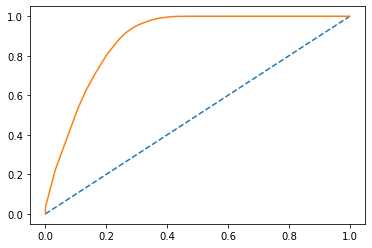

In [331]:
y_prob_tr1 = dt_t.predict_proba(Xnew)[:,1]
auc_tr1 = roc_auc_score(ynew,y_prob_tr1)
fpr_tr1 , tpr_tr1, thr_tr1 = roc_curve(ynew,y_prob_tr1)
print('AUC:',auc_tr1)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr_tr1,tpr_tr1)
plt.show()

AUC 0.8484639473468102


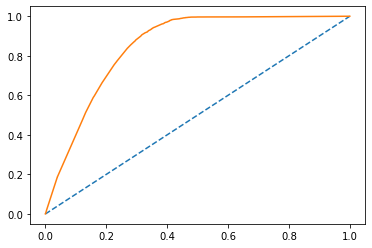

In [332]:
y_prob_te1 = dt_t.predict_proba(x_test)[:,1]
auc_te1 = roc_auc_score(y_test,y_prob_te1)
fpr_te1, tpr_te1, thr_te1 = roc_curve(y_test,y_prob_te1)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr_te1,tpr_te1)
print('AUC',auc_te1)
plt.show()

In [333]:
# Threshold optimisation using tpr, fpr
optimal_tr1 = np.argmax(tpr_tr1 - fpr_tr1)
optimal_thresh_tr1 = thr_tr1[optimal_tr1]
print('Best threshold train:',optimal_thresh_tr1)
optimal_te1 = np.argmax(tpr_te1 - fpr_te1)
optimal_thresh_te1 = thr_te1[optimal_te1]
print('Best threshold test:',optimal_thresh_te1)

Best threshold train: 0.29393939393939394
Best threshold test: 0.2765957446808511


In [335]:
# Using tpr and fpr
y_train_pr1 = []
for i in range(0,len(y_prob_tr1)):
    if np.array(y_prob_tr1)[i] > 0.28:
        a=1
    else:
        a=0
    y_train_pr1.append(a)
# Testing prediction
y_test_pr1 = []
for i in range(0,len(y_prob_te1)):
    if np.array(y_prob_te1)[i]> 0.28:
        b=1
    else:
        b=0
    y_test_pr1.append(b)

In [500]:
print('Balanced Decision Tree threshold tuned:\n')
print(classification_report(y_test, y_test_pr1))
print('Training Accuracy: ', round(dt_t.score(Xnew,ynew),4),'\tTesting Accuracy: ',round(dt_t.score(x_test,y_test),4))
print('Training Precision:', round(precision_score(ynew,y_train_pr1),4),'\tTesting Precision:',round(precision_score(y_test,y_test_pr1),4))
print('Training Recall:   ', round(recall_score(ynew,y_train_pr1),4),'\tTesting Recall:   ',round(recall_score(y_test,y_test_pr1),4))

Balanced Decision Tree threshold tuned:

              precision    recall  f1-score   support

           0       0.98      0.68      0.81    100195
           1       0.29      0.91      0.44     14138

    accuracy                           0.71    114333
   macro avg       0.63      0.79      0.62    114333
weighted avg       0.90      0.71      0.76    114333

Training Accuracy:  0.8009 	Testing Accuracy:  0.7949
Training Precision: 0.5628 	Testing Precision: 0.2876
Training Recall:    0.9399 	Testing Recall:    0.9054


In [516]:
print(round(f1_score(ynew,y_train_pr1),4))
print(round(f1_score(y_test,y_test_pr1),4))

0.7041
0.4365


In [496]:
pred_tr = dt_t.predict_proba(Xnew)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(ynew)):
        if np.array(pred_tr[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,6),round(precision_score(ynew,custom_cutoff_data),4))

0.0 0.383
0.1 0.5098
0.2 0.5457
0.3 0.5738
0.4 0.5875
0.5 0.6301
0.6 0.66
0.7 1.0
0.8 1.0
0.9 1.0


In [412]:
pred_tr = dt_t.predict_proba(Xnew)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(ynew)):
        if np.array(pred_tr[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,6),round(recall_score(ynew,custom_cutoff_data),4))

0.0 1.0
0.1 0.99
0.2 0.9614
0.3 0.9203
0.4 0.8862
0.5 0.7083
0.6 0.5443
0.7 0.0334
0.8 0.0334
0.9 0.0334


In [413]:
pred_te = dt_t.predict_proba(x_test)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(y_test)):
        if np.array(pred_te[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,3),round(precision_score(y_test,custom_cutoff_data),4))

0.0 0.177
0.1 0.2527
0.2 0.2755
0.3 0.2948
0.4 0.3041
0.5 0.3344
0.6 0.3539
0.7 0.0
0.8 0.0
0.9 0.0


In [414]:
pred_te = dt_t.predict_proba(x_test)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(y_test)):
        if np.array(pred_te[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,3),round(recall_score(y_test,custom_cutoff_data),4))

0.0 0.9968
0.1 0.978
0.2 0.9327
0.3 0.88
0.4 0.8421
0.5 0.665
0.6 0.513
0.7 0.0
0.8 0.0
0.9 0.0


In [218]:
# Cross-Validation Score

decision_tree_tuned_model = DecisionTreeClassifier(criterion = 'entropy', 
                                                   max_depth = 9, 
                                                   min_samples_split = 7)

scores = cross_val_score(estimator = decision_tree_tuned_model, 
                         X = Xnew, 
                         y = ynew, 
                         cv = 10, 
                         scoring ='precision')

scores

array([0.59955854, 0.61153586, 0.61035213, 0.62112463, 0.61671952,
       0.64077974, 0.63081022, 0.61737048, 0.63114924, 0.61569008])

### Random Forest 

In [250]:
from sklearn.ensemble import RandomForestClassifier

In [246]:
from sklearn.metrics import classification_report, accuracy_score
rf= RandomForestClassifier()
rf= rf.fit(Xnew,ynew)
y_pred_rf = rf.predict(x_test)
print(classification_report(y_test, y_pred_rf))
print('Training Accuracy:',rf.score(Xnew,ynew))
print('Testing Accuracy:', rf.score(x_test,y_test))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89    100195
           1       0.31      0.39      0.34     14138

    accuracy                           0.82    114333
   macro avg       0.61      0.63      0.62    114333
weighted avg       0.84      0.82      0.83    114333

Training Accuracy: 0.966983795427471
Testing Accuracy: 0.817559234866574


In [99]:
from sklearn.model_selection import RandomizedSearchCV
g= {'criterion':['entropy','gini'],
   'max_depth': [5,6,7,8,9,10],
                     'min_samples_split': [3,4,5,6,7,8,9],
                     'n_estimators':[200,300]}
gs= RandomizedSearchCV(RandomForestClassifier(),
                      param_distributions=g,
                      n_iter=10,
                      scoring=precision_score,
                      cv=3,
                      n_jobs=-1,
                      verbose=3)
gs.fit(Xnew,ynew)
print('Best parameters for Decision Tree Classifier: ', gs.best_params_, '\n')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for Decision Tree Classifier:  {'n_estimators': 200, 'min_samples_split': 6, 'max_depth': 9, 'criterion': 'entropy'} 



In [501]:
from sklearn.metrics import classification_report, accuracy_score
rf_t= RandomForestClassifier(n_estimators= 200, max_depth=9, min_samples_split=6,criterion='entropy')
rf_t = rf_t.fit(Xnew,ynew)
y_pred_rf_t = rf_t.predict(x_test)
print('Balanced Random Forest Tuned:\n')
print(classification_report(y_test, y_pred_rf_t))
print('Training Accuracy: ', round(rf_t.score(Xnew,ynew),4),'\tTesting Accuracy: ',round(rf_t.score(x_test,y_test),4))
print('Training Precision:', round(precision_score(ynew,rf_t.predict(Xnew)),4),'\tTesting Precision:',round(precision_score(y_test,y_pred_rf_t),4))
print('Training Recall:   ', round(recall_score(ynew,rf_t.predict(Xnew)),4),'\tTesting Recall:   ',round(recall_score(y_test,y_pred_rf_t),4))

Balanced Random Forest Tuned:

              precision    recall  f1-score   support

           0       0.96      0.78      0.86    100195
           1       0.33      0.76      0.46     14138

    accuracy                           0.78    114333
   macro avg       0.64      0.77      0.66    114333
weighted avg       0.88      0.78      0.81    114333

Training Accuracy:  0.8031 	Testing Accuracy:  0.7765
Training Precision: 0.6162 	Testing Precision: 0.326
Training Recall:    0.7962 	Testing Recall:    0.7565


AUC: 0.8841205948450441


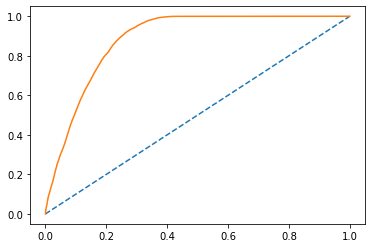

In [248]:
y_prob_tr2 = rf_t.predict_proba(Xnew)[:,1]
auc_tr2 = roc_auc_score(ynew,y_prob_tr2)
fpr_tr2 , tpr_tr2, thr_tr2 = roc_curve(ynew,y_prob_tr2)
print('AUC:',auc_tr2)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr_tr2,tpr_tr2)
plt.show()

AUC: 0.85437123101535


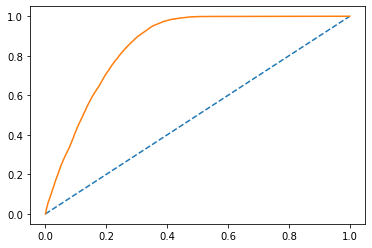

In [249]:
y_prob_te2 = rf_t.predict_proba(x_test)[:,1]
auc_te2 = roc_auc_score(y_test,y_prob_te2)
fpr_te2 , tpr_te2, thr_te2 = roc_curve(y_test,y_prob_te2)
print('AUC:',auc_te2)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr_te2,tpr_te2)
plt.show()

In [250]:
# Finding best threshold using roc-curve
optimal_tr2 = np.argmax(tpr_tr2 - fpr_tr2)
optimal_thresh_tr2 = thr_tr2[optimal_tr2]
print('Best threshold train:',optimal_thresh_tr2)
optimal_te2 = np.argmax(tpr_te2 - fpr_te2)
optimal_thresh_te2 = thr_te2[optimal_te2]
print('Best threshold test:',optimal_thresh_te2)

Best threshold train: 0.3430778437373386
Best threshold test: 0.2563728498524744


In [251]:
# Getting y_train_pred and y_test_pred using the thresholds obtained above
y_train_pr2 = []
for i in range(0,len(y_prob_tr2)):
    if np.array(y_prob_tr2)[i] > 0.30:
        a=1
    else:
        a=0
    y_train_pr2.append(a)
# Testing prediction
y_test_pr2 = []
for i in range(0,len(y_prob_te2)):
    if np.array(y_prob_te2)[i]> 0.30:
        b=1
    else:
        b=0
    y_test_pr2.append(b)

In [252]:
# The performance of the model after threshold tuning
print(classification_report(y_test, y_test_pr2))
print('Training Accuracy', rf_t.score(Xnew,ynew),'\tTesting Accuracy', rf_t.score(x_test,y_test))
print('Training Precision', precision_score(ynew,y_train_pr2),'\tTesting Precision',precision_score(y_test,y_test_pr2))
print('Training Recall', recall_score(ynew,y_train_pr2),'\tTesting Recall',recall_score(y_test,y_test_pr2))

              precision    recall  f1-score   support

           0       0.98      0.68      0.80    100195
           1       0.29      0.92      0.44     14138

    accuracy                           0.71    114333
   macro avg       0.63      0.80      0.62    114333
weighted avg       0.90      0.71      0.76    114333

Training Accuracy 0.8035901369147669 	Testing Accuracy 0.7765474534911181
Training Precision 0.5575851456849695 	Testing Precision 0.2859339645438369
Training Recall 0.9428385990125403 	Testing Recall 0.9206394115150658


In [254]:
# Threshold optimisation using geometric mean
y_pb_gm_tr2 = dt_t.predict_proba(Xnew)[:,1]
y_pb_gm_te2 = dt_t.predict_proba(x_test)[:,1]
gmeans_tr2 = np.argmax(np.sqrt(tpr_tr2 * (1-fpr_tr2)))
opt_thresh_tr2 = thr_tr2[gmeans_tr2]
print('Best train threshold', opt_thresh_tr2)
gmeans_te2 = np.argmax(np.sqrt(tpr_te2 * (1-fpr_te2)))
opt_thresh_te2 = thr_te2[gmeans_te2]
print('Best test threshold', opt_thresh_te2)

Best train threshold 0.3657510787933671
Best test threshold 0.3515327947826457


In [255]:
# Using geometric mean determining y_train_pred and y_test_pred
y_train_gm2 = []
for i in range(0,len(y_pb_gm_tr2)):
    if np.array(y_pb_gm_tr2)[i] > 0.36:
        a=1
    else:
        a=0
    y_train_gm2.append(a)
# Testing prediction
y_test_gm2 = []
for i in range(0,len(y_pb_gm_te2)):
    if np.array(y_pb_gm_te2)[i]> 0.36:
        b=1
    else:
        b=0
    y_test_gm2.append(b)

In [256]:
# Determining the performance of the model after threshold tuning
print(classification_report(y_test, y_test_gm2))
print('Training Accuracy', rf_t.score(Xnew,ynew),'\tTesting Accuracy', rf_t.score(x_test,y_test))
print('Training Precision', precision_score(ynew,y_train_gm2),'\tTesting Precision',precision_score(y_test,y_test_gm2))
print('Training Recall', recall_score(ynew,y_train_gm2),'\tTesting Recall',recall_score(y_test,y_test_gm2))

              precision    recall  f1-score   support

           0       0.97      0.72      0.83    100195
           1       0.30      0.85      0.45     14138

    accuracy                           0.74    114333
   macro avg       0.64      0.79      0.64    114333
weighted avg       0.89      0.74      0.78    114333

Training Accuracy 0.8035901369147669 	Testing Accuracy 0.7765474534911181
Training Precision 0.5854744052019372 	Testing Precision 0.3017764841672103
Training Recall 0.8995387218655108 	Testing Recall 0.8506860942141745


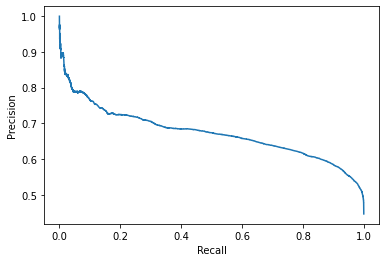

In [261]:
# Finding best threshold using precision-recall curve
y_prec_tr1 = rf_t.predict_proba(Xnew)[:,1]
pre_tr1, rec_tr1, thresh_tr1 = precision_recall_curve(ynew,y_prec_tr1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(rec_tr1, pre_tr1)
plt.show()

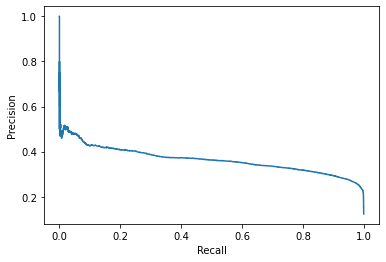

In [262]:
# Finding best threshold using precision-recall curve
y_prec_te1 = rf_t.predict_proba(x_test)[:,1]
pre_te1, rec_te1, thresh_te1 = precision_recall_curve(y_test ,y_prec_te1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(rec_te1, pre_te1)
plt.show()

In [275]:
# Finding the best threshold based on the above curves
f1_tr1 = np.argmax((2 * pre_tr1 * rec_tr1)/(pre_tr1 + rec_tr1))
opt_thr_f1_tr1 = thresh_tr1[f1_tr1]
print('Best Threshold Train',opt_thr_f1_tr1)
f1_te1 = np.argmax((2 * pre_te1 * rec_te1)/(pre_te1 + rec_te1))
opt_thr_f1_te1 = thresh_te1[f1_te1]
print('Best Threshold Train', opt_thr_f1_te1)

Best Threshold Train 0.40262768366361307
Best Threshold Train 0.4962203812378133


In [350]:
from sklearn.metrics import roc_curve
pred = rf_t.predict_proba(x_test)[:,1]
fpr,tpr,thres=roc_curve(y_test,pred)
precision=[]
for i in thres:
    y_predf=np.where(pred>i,1,0)
    precision.append(precision_score(y_test,y_predf))
precision=pd.concat([pd.Series(thres),pd.Series(precision)],axis=1)
precision.columns=['Thresholds','Precision scores']
precision.sort_values(by='Precision scores',ascending=False)

,Thresholds,Precision scores
2,0.734536,1.000000
4,0.733408,0.750000
7,0.732388,0.750000
6,0.732479,0.727273
5,0.732923,0.714286
9,0.732220,0.687500
8,0.732362,0.666667
13,0.731822,0.652174
10,0.732160,0.647059
14,0.731508,0.640000


In [351]:
from sklearn.metrics import roc_curve
pred = rf_t.predict_proba(x_test)[:,1]
fpr,tpr,thres=roc_curve(y_test,pred)
recall=[]
for i in thres:
    y_predf=np.where(pred>i,1,0)
    recall.append(recall_score(y_test,y_predf))
recall=pd.concat([pd.Series(thres),pd.Series(recall)],axis=1)
recall.columns=['Thresholds','recall scores']
recall.sort_values(by='recall scores',ascending=False).head(25)

,Thresholds,recall scores
27354,0.000012,1.0
27321,0.000067,1.0
27330,0.000055,1.0
27329,0.000059,1.0
27328,0.000062,1.0
27327,0.000062,1.0
27326,0.000062,1.0
27325,0.000064,1.0
27324,0.000065,1.0
27323,0.000066,1.0


In [272]:
# Using geometric mean determining y_train_pred and y_test_pred
y_train_f11 = []
for i in range(0,len(y_prec_tr1)):
    if np.array(y_prec_tr1)[i] > 0.449:
        a=1
    else:
        a=0
    y_train_f11.append(a)
# Testing prediction
y_test_f11 = []
for i in range(0,len(y_prec_te1)):
    if np.array(y_prec_te1)[i]> 0.449:
        b=1
    else:
        b=0
    y_test_f11.append(b)

In [273]:
# Determining the performance of the model after threshold tuning
print(classification_report(y_test, y_test_f11))
print('Training Accuracy', rf_t.score(Xnew,ynew),'\tTesting Accuracy', rf_t.score(x_test,y_test))
print('Training Precision', precision_score(ynew,y_train_f11),'\tTesting Precision',precision_score(y_test,y_test_f11))
print('Training Recall', recall_score(ynew,y_train_f11),'\tTesting Recall',recall_score(y_test,y_test_f11))

              precision    recall  f1-score   support

           0       0.96      0.76      0.85    100195
           1       0.32      0.79      0.45     14138

    accuracy                           0.77    114333
   macro avg       0.64      0.78      0.65    114333
weighted avg       0.88      0.77      0.80    114333

Training Accuracy 0.8035901369147669 	Testing Accuracy 0.7765474534911181
Training Precision 0.6070317678853705 	Testing Precision 0.3193200354863635
Training Recall 0.8278319927679006 	Testing Recall 0.7892205403876079


In [341]:
# Threshold tuning by testing all possible thresholds
def to_labels(pos_probs, thresholds):
    return (pos_probs >= thresholds).astype('int')
y_prob_thrtr1 = rf_t.predict_proba(Xnew)[:,1]
thr_tune_tr1 = np.arange(0,1,0.001)
scores_tr1 = [precision_score(ynew, to_labels(y_prob_thrtr1,t)) for t in thr_tune_tr1]
ix_tr1 = np.argmax(scores_tr1)
opt_thrtr1 = thr_tune_tr1[ix_tr1]
print('Best Train Threshold', opt_thrtr1)

Best Train Threshold 0.734


In [342]:
y_prob_thrte1 = rf_t.predict_proba(x_test)[:,1]
thr_tune_te1 = np.arange(0,1,0.001)
scores_te1 = [precision_score(y_test , to_labels(y_prob_thrte1,t)) for t in thr_tune_te1]
ix_te1 = np.argmax(scores_te1)
opt_thrte1 = thr_tune_te1[ix_te1]
print('Best Test Threshold', opt_thrte1)

Best Train Threshold 0.735


In [408]:
y_train_prec1 = []
for i in range(0,len(y_prob_thrtr1)):
    if np.array(y_prob_thrtr1)[i] > 0.0001:
        a=1
    else:
        a=0
    y_train_prec1.append(a)
# Testing prediction
y_test_prec1 = []
for i in range(0,len(y_prob_thrte1)):
    if np.array(y_prob_thrte1)[i]> 0.20:
        b=1
    else:
        b=0
    y_test_prec1.append(b)

In [502]:
print('Balanced Random Forest model Threshold Tuned:\n')
print(classification_report(y_test, y_test_prec1))
print('Training Accuracy: ', round(rf_t.score(Xnew,ynew),4),'\tTesting Accuracy: ',round(rf_t.score(x_test,y_test),4))
print('Training Precision:', round(precision_score(ynew,y_train_prec1),4),'\tTesting Precision:',round(precision_score(y_test,y_test_prec1),4))
print('Training Recall:   ', round(recall_score(ynew,y_train_prec1),4),'\tTesting Recall:   ',round(recall_score(y_test,y_test_prec1),4))

Balanced Random Forest model Threshold Tuned:

              precision    recall  f1-score   support

           0       0.99      0.63      0.77    100195
           1       0.27      0.96      0.42     14138

    accuracy                           0.67    114333
   macro avg       0.63      0.80      0.60    114333
weighted avg       0.90      0.67      0.73    114333

Training Accuracy:  0.8031 	Testing Accuracy:  0.7765
Training Precision: 0.2839 	Testing Precision: 0.2697
Training Recall:    1.0 	Testing Recall:    0.9595


In [517]:
print(round(f1_score(ynew,y_train_prec1),4))
print(round(f1_score(y_test,y_test_prec1),4))

0.4423
0.4211


In [410]:
pred_tr = rf_t.predict_proba(Xnew)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(ynew)):
        if np.array(pred_tr[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,6),round(precision_score(ynew,custom_cutoff_data),4))

0.0 0.2815
0.1 0.4997
0.2 0.5338
0.3 0.5571
0.4 0.5868
0.5 0.6157
0.6 0.6834
0.7 0.828
0.8 0.0
0.9 0.0


In [394]:
pred_tr = rf_t.predict_proba(Xnew)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(ynew)):
        if np.array(pred_tr[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,3),round(recall_score(ynew,custom_cutoff_data),4))

0.0 1.0
0.1 0.9955
0.2 0.974
0.3 0.9421
0.4 0.8896
0.5 0.7949
0.6 0.3962
0.7 0.0254
0.8 0.0
0.9 0.0


In [395]:
pred_te = rf_t.predict_proba(x_test)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(y_test)):
        if np.array(pred_te[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,3),round(precision_score(y_test,custom_cutoff_data),4))

0.0 0.1237
0.1 0.2466
0.2 0.2697
0.3 0.2859
0.4 0.3056
0.5 0.3263
0.6 0.3733
0.7 0.5009
0.8 0.0
0.9 0.0


In [396]:
pred_te = rf_t.predict_proba(x_test)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(y_test)):
        if np.array(pred_te[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,3),round(recall_score(y_test,custom_cutoff_data),4))

0.0 1.0
0.1 0.987
0.2 0.9595
0.3 0.9206
0.4 0.8559
0.5 0.758
0.6 0.3814
0.7 0.0204
0.8 0.0
0.9 0.0


### Ada Boost

In [106]:
from sklearn.ensemble import AdaBoostClassifier

In [165]:
adb= AdaBoostClassifier()
adb= adb.fit(Xnew,ynew)
y_pred_adb = adb.predict(x_test)
print(classification_report(y_test,y_pred_adb))
print('Training Accuracy', adb.score(Xnew,ynew),'\tTesting Accuracy', adb.score(x_test,y_test))
print('Training Precision', precision_score(ynew,adb.predict(Xnew)),'\tTesting Precision',precision_score(y_test,y_pred_adb))
print('Training Recall', recall_score(ynew,adb.predict(Xnew)),'\tTesting Recall',recall_score(y_test,y_pred_adb))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87    100195
           1       0.33      0.70      0.45     14138

    accuracy                           0.79    114333
   macro avg       0.64      0.75      0.66    114333
weighted avg       0.87      0.79      0.82    114333

Training Accuracy 0.7977389269030536 	Testing Accuracy 0.7873317414919577
Training Precision 0.620585097977244 	Testing Precision 0.3305809888463459
Training Recall 0.7267039080300244 	Testing Recall 0.7022916961380676


In [108]:
from sklearn.model_selection import RandomizedSearchCV
g= {'n_estimators':[100,150,200,250,300]}
gs= RandomizedSearchCV(AdaBoostClassifier(),
                      param_distributions=g,
                      n_iter=10,
                      scoring=precision_score,
                      cv=3,
                      n_jobs=-1,
                      verbose=3)
gs.fit(Xnew,ynew)
print('Best parameters for Decision Tree Classifier: ', gs.best_params_, '\n')

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters for Decision Tree Classifier:  {'n_estimators': 100} 



In [503]:
adb_t= AdaBoostClassifier(n_estimators=100,learning_rate=1,random_state=10)
adb_t= adb_t.fit(Xnew,ynew)
y_pred_adb_t= adb_t.predict(x_test)
print('Balanced Ada Boost Model Tuned:\n')
print(classification_report(y_test,y_pred_adb_t))
print('Training Accuracy: ', round(adb_t.score(Xnew,ynew),4),'\tTesting Accuracy: ',round(adb_t.score(x_test,y_test),4))
print('Training Precision:', round(precision_score(ynew,adb_t.predict(Xnew)),4),'\tTesting Precision:',round(precision_score(y_test,y_pred_adb_t),4))
print('Training Recall:   ', round(recall_score(ynew,adb_t.predict(Xnew)),4),'\tTesting Recall:   ',round(recall_score(y_test,y_pred_adb_t),4))

Balanced Ada Boost Model Tuned:

              precision    recall  f1-score   support

           0       0.95      0.79      0.87    100195
           1       0.33      0.72      0.45     14138

    accuracy                           0.78    114333
   macro avg       0.64      0.76      0.66    114333
weighted avg       0.87      0.78      0.81    114333

Training Accuracy:  0.8011 	Testing Accuracy:  0.7849
Training Precision: 0.6213 	Testing Precision: 0.3297
Training Recall:    0.7513 	Testing Recall:    0.7153


AUC: 0.8796011290761769


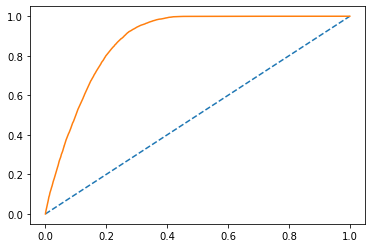

In [486]:
y_prob_tr3 = adb_t.predict_proba(Xnew)[:,1]
auc_tr3 = roc_auc_score(ynew,y_prob_tr3)
fpr_tr3 , tpr_tr3, thr_tr3 = roc_curve(ynew,y_prob_tr3)
print('AUC:',auc_tr3)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr_tr3,tpr_tr3)
plt.show()

AUC: 0.8520081858200812


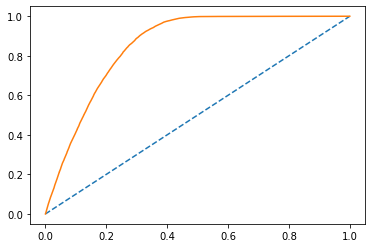

In [487]:
y_prob_te3 = adb_t.predict_proba(x_test)[:,1]
auc_te3 = roc_auc_score(y_test,y_prob_te3)
fpr_te3 , tpr_te3, thr_te3 = roc_curve(y_test,y_prob_te3)
print('AUC:',auc_te3)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr_te3,tpr_te3)
plt.show()

In [488]:
optimal_tr3 = np.argmax(tpr_tr3 - fpr_tr3)
optimal_thresh_tr3 = thr_tr3[optimal_tr3]
print('Best threshold train:',optimal_thresh_tr3)
optimal_te3 = np.argmax(tpr_te3 - fpr_te3)
optimal_thresh_te3 = thr_te3[optimal_te3]
print('Best threshold test:',optimal_thresh_te3)

Best threshold train: 0.4980471883248279
Best threshold test: 0.49753412666885416


In [489]:
y_train_pr3 = []
for i in range(0,len(y_prob_tr3)):
    if np.array(y_prob_tr3)[i] > 0.00001:
        a=1
    else:
        a=0
    y_train_pr3.append(a)
# Testing prediction
y_test_pr3 = []
for i in range(0,len(y_prob_te3)):
    if np.array(y_prob_te3)[i]> 0.497:
        b=1
    else:
        b=0
    y_test_pr3.append(b)

In [504]:
print('Balanced Ada Boost model Threshold Tuned:\n')
print(classification_report(y_test, y_test_pr3))
print('Training Accuracy: ', round(adb_t.score(Xnew,ynew),4),'\tTesting Accuracy: ',round(adb_t.score(x_test,y_test),4))
print('Training Precision:', round(precision_score(ynew,y_train_pr3),4),'\tTesting Precision:',round(precision_score(y_test,y_test_pr3),4))
print('Training Recall:   ', round(recall_score(ynew,y_train_pr3),4),'\tTesting Recall:   ',round(recall_score(y_test,y_test_pr3),4))

Balanced Ada Boost model Threshold Tuned:

              precision    recall  f1-score   support

           0       0.99      0.65      0.78    100195
           1       0.27      0.94      0.42     14138

    accuracy                           0.68    114333
   macro avg       0.63      0.79      0.60    114333
weighted avg       0.90      0.68      0.74    114333

Training Accuracy:  0.8011 	Testing Accuracy:  0.7849
Training Precision: 0.2815 	Testing Precision: 0.2742
Training Recall:    1.0 	Testing Recall:    0.9404


In [518]:
print(round(f1_score(ynew,y_train_pr3),4))
print(round(f1_score(y_test,y_test_pr3),4))

0.4393
0.4246


In [491]:
pred_tr = adb_t.predict_proba(Xnew)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(ynew)):
        if np.array(pred_tr[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,6),round(precision_score(ynew,custom_cutoff_data),4))

0.0 0.2815
0.1 0.2815
0.2 0.2815
0.3 0.2815
0.4 0.2815
0.5 0.6213
0.6 0.0
0.7 0.0
0.8 0.0
0.9 0.0


In [420]:
pred_tr = adb_t.predict_proba(Xnew)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(ynew)):
        if np.array(pred_tr[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,6),round(recall_score(ynew,custom_cutoff_data),4))

0.0 1.0
0.1 1.0
0.2 1.0
0.3 1.0
0.4 1.0
0.5 0.752
0.6 0.0
0.7 0.0
0.8 0.0
0.9 0.0


In [492]:
pred_te = adb_t.predict_proba(x_test)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(y_test)):
        if np.array(pred_te[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,6),round(precision_score(y_test,custom_cutoff_data),4))

0.0 0.1237
0.1 0.1237
0.2 0.1237
0.3 0.1237
0.4 0.1237
0.5 0.3297
0.6 0.0
0.7 0.0
0.8 0.0
0.9 0.0


In [494]:
pred_te = adb_t.predict_proba(x_test)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(y_test)):
        if np.array(pred_te[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,6),round(recall_score(y_test,custom_cutoff_data),4))

0.0 1.0
0.1 1.0
0.2 1.0
0.3 1.0
0.4 1.0
0.5 0.7153
0.6 0.0
0.7 0.0
0.8 0.0
0.9 0.0


### Gradient Boost

In [118]:
from sklearn.ensemble import GradientBoostingClassifier

In [172]:
gb= GradientBoostingClassifier()
gb= gb.fit(Xnew,ynew)
y_pred_gb= gb.predict(x_test)
print(classification_report(y_test,y_pred_gb))
print('Training Accuracy', gb.score(Xnew,ynew),'\tTesting Accuracy', gb.score(x_test,y_test))
print('Training Precision', precision_score(ynew,gb.predict(Xnew)),'\tTesting Precision',precision_score(y_test,y_pred_gb))
print('Training Recall', recall_score(ynew,gb.predict(Xnew)),'\tTesting Recall',recall_score(y_test,y_pred_gb))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87    100195
           1       0.33      0.72      0.46     14138

    accuracy                           0.79    114333
   macro avg       0.64      0.76      0.66    114333
weighted avg       0.88      0.79      0.82    114333

Training Accuracy 0.8082945132466415 	Testing Accuracy 0.7863084148933379
Training Precision 0.6296626221330383 	Testing Precision 0.3323561982932708
Training Recall 0.7766443449799336 	Testing Recall 0.721742820766728


In [120]:
from sklearn.model_selection import RandomizedSearchCV
g= {'n_estimators':[100,150,200,250,300],
   'min_samples_split': [3,4,5,6,7],
   'max_depth': [5,6,7,8,9,10],
   'min_samples_leaf': [4,5,6,7,8,9]}
gs= RandomizedSearchCV(GradientBoostingClassifier(),
                      param_distributions=g,
                      n_iter=10,
                      scoring=precision_score,
                      cv=3,
                      n_jobs=-1,
                      verbose=3)
gs.fit(Xnew,ynew)
print('Best parameters for Decision Tree Classifier: ', gs.best_params_, '\n')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for Decision Tree Classifier:  {'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 10} 



In [506]:
gb_t = GradientBoostingClassifier(learning_rate=0.1,n_estimators=200, min_samples_split=3,
                                  min_samples_leaf=5,max_depth=10,random_state=10,)
gb_t = gb_t.fit(Xnew,ynew)
y_pred_gb_t = gb_t.predict(x_test)
print('Balanced Gradient Boost Model Tuned:\n')
print(classification_report(y_test,y_pred_gb_t))
print('Training Accuracy: ', round(gb_t.score(Xnew,ynew),4),'\tTesting Accuracy: ',round(gb_t.score(x_test,y_test),4))
print('Training Precision:', round(precision_score(ynew,gb_t.predict(Xnew)),4),'\tTesting Precision:',round(precision_score(y_test,y_pred_gb_t),4))
print('Training Recall:   ', round(recall_score(ynew,gb_t.predict(Xnew)),4),'\tTesting Recall:   ',round(recall_score(y_test,y_pred_gb_t),4))

Balanced Gradient Boost Model Tuned:

              precision    recall  f1-score   support

           0       0.92      0.88      0.90    100195
           1       0.35      0.47      0.40     14138

    accuracy                           0.83    114333
   macro avg       0.64      0.67      0.65    114333
weighted avg       0.85      0.83      0.84    114333

Training Accuracy:  0.8804 	Testing Accuracy:  0.8279
Training Precision: 0.7839 	Testing Precision: 0.3533
Training Recall:    0.7937 	Testing Recall:    0.4715


AUC: 0.953940770008342


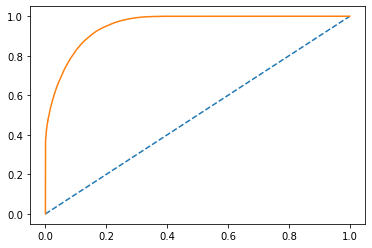

In [437]:
y_prob_tr4 = gb_t.predict_proba(Xnew)[:,1]
auc_tr4 = roc_auc_score(ynew,y_prob_tr4)
fpr_tr4 , tpr_tr4, thr_tr4 = roc_curve(ynew,y_prob_tr4)
print('AUC:',auc_tr4)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr_tr4,tpr_tr4)
plt.show()

AUC: 0.848259243252006


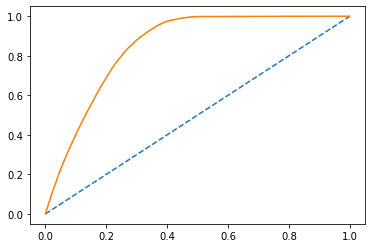

In [438]:
y_prob_te4 = gb_t.predict_proba(x_test)[:,1]
auc_te4 = roc_auc_score(y_test,y_prob_te4)
fpr_te4 , tpr_te4, thr_te4 = roc_curve(y_test,y_prob_te4)
print('AUC:',auc_te4)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr_te4,tpr_te4)
plt.show()

In [439]:
optimal_tr4 = np.argmax(tpr_tr4 - fpr_tr4)
optimal_thresh_tr4 = thr_tr4[optimal_tr4]
print('Best threshold train:',optimal_thresh_tr4)
optimal_te4 = np.argmax(tpr_te4 - fpr_te4)
optimal_thresh_te4 = thr_te4[optimal_te4]
print('Best threshold test:',optimal_thresh_te4)

Best threshold train: 0.3540451168595653
Best threshold test: 0.14784182848845165


In [440]:
y_train_pr4 = []
for i in range(0,len(y_prob_tr4)):
    if np.array(y_prob_tr4)[i] > 0.00001:
        a=1
    else:
        a=0
    y_train_pr4.append(a)
# Testing prediction
y_test_pr4 = []
for i in range(0,len(y_prob_te4)):
    if np.array(y_prob_te4)[i]> 0.1:
        b=1
    else:
        b=0
    y_test_pr4.append(b)

In [520]:
print('Balanced Gradient Boost Model Threshold Tuned:\n')
print(classification_report(y_test, y_test_pr4))
print('Training Accuracy: ', round(gb_t.score(Xnew,ynew),4),'\tTesting Accuracy: ',round(gb_t.score(x_test,y_test),4))
print('Training Precision:', round(precision_score(ynew,y_train_pr4),4),'\tTesting Precision:',round(precision_score(y_test,y_test_pr4),4))
print('Training Recall:   ', round(recall_score(ynew,y_train_pr4),4),'\tTesting Recall:   ',round(recall_score(y_test,y_test_pr4),4))

Balanced Gradient Boost Model Threshold Tuned:

              precision    recall  f1-score   support

           0       0.99      0.62      0.77    100195
           1       0.26      0.96      0.41     14138

    accuracy                           0.67    114333
   macro avg       0.63      0.79      0.59    114333
weighted avg       0.90      0.67      0.72    114333

Training Accuracy:  0.8804 	Testing Accuracy:  0.8279
Training Precision: 0.2815 	Testing Precision: 0.2647
Training Recall:    1.0 	Testing Recall:    0.9593


In [521]:
print(round(f1_score(ynew,y_train_pr4),4))
print(round(f1_score(y_test,y_test_pr4),4))

0.4393
0.4149


In [435]:
pred_tr = gb_t.predict_proba(Xnew)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(ynew)):
        if np.array(pred_tr[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,6),round(precision_score(ynew,custom_cutoff_data),4))

0.0 0.2815
0.1 0.5372
0.2 0.5986
0.3 0.654
0.4 0.7074
0.5 0.7785
0.6 0.8769
0.7 0.9658
0.8 0.9987
0.9 0.9999


In [425]:
pred_tr = gb_t.predict_proba(Xnew)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(ynew)):
        if np.array(pred_tr[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,6),round(recall_score(ynew,custom_cutoff_data),4))

0.0 1.0
0.1 0.9951
0.2 0.9718
0.3 0.9336
0.4 0.881
0.5 0.7772
0.6 0.5964
0.7 0.4246
0.8 0.3363
0.9 0.2678


In [426]:
pred_te = gb_t.predict_proba(x_test)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(y_test)):
        if np.array(pred_te[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,3),round(precision_score(y_test,custom_cutoff_data),4))

0.0 0.1237
0.1 0.2647
0.2 0.2938
0.3 0.3173
0.4 0.3334
0.5 0.3548
0.6 0.3897
0.7 0.4192
0.8 0.4667
0.9 1.0


In [428]:
pred_te = gb_t.predict_proba(x_test)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(y_test)):
        if np.array(pred_te[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,3),round(recall_score(y_test,custom_cutoff_data),4))

0.0 1.0
0.1 0.9588
0.2 0.8743
0.3 0.7722
0.4 0.6457
0.5 0.4714
0.6 0.2497
0.7 0.0748
0.8 0.005
0.9 0.0001


### XGboost

In [181]:
import xgboost
from xgboost import XGBClassifier

In [182]:
xgb= XGBClassifier()
xgb= xgb.fit(Xnew,ynew)
y_pred_xgb= xgb.predict(x_test)
print(classification_report(y_test,y_pred_xgb))
print('Training Accuracy', xgb.score(Xnew,ynew),'\tTesting Accuracy', xgb.score(x_test,y_test))
print('Training Precision', precision_score(ynew,xgb.predict(Xnew)),'\tTesting Precision',precision_score(y_test,y_pred_xgb))
print('Training Recall', recall_score(ynew,xgb.predict(Xnew)),'\tTesting Recall',recall_score(y_test,y_pred_xgb))

[19:51:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.93      0.87      0.90    100195
           1       0.36      0.50      0.42     14138

    accuracy                           0.83    114333
   macro avg       0.64      0.69      0.66    114333
weighted avg       0.86      0.83      0.84    114333

Training Accuracy 0.8554262820408336 	Testing Accuracy 0.8265417683433479
Training Precision 0.7391916759433855 	Testing Precision 0.3571213489912677
Training Recall 0.752622509050114 	Testing Recall 0.5033243740274438


In [72]:
xgb.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)>

In [73]:
from sklearn.model_selection import RandomizedSearchCV
g= {'n_estimators':[100,150,200,250,300],
   'max_depth': [5,6,7,8,9,10],
   }
gs= RandomizedSearchCV(XGBClassifier(),
                      param_distributions=g,
                      n_iter=10,
                      scoring=precision_score,
                      cv=3,
                      n_jobs=-1,
                      verbose=3)
gs.fit(Xnew,ynew)
print('Best parameters for Decision Tree Classifier: ', gs.best_params_, '\n')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[13:35:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters for Decision Tree Classifier:  {'n_estimators': 300, 'max_depth': 10} 



In [510]:
xgb_t= XGBClassifier(n_estimators=300,max_depth=10)
xgb_t = xgb_t.fit(Xnew,ynew)
y_pred_xgb_t = xgb_t.predict(x_test)
print('Balanced Xgboost model Tuned:\n')
print(classification_report(y_test,y_pred_xgb_t))
print('Training Accuracy: ', round(xgb_t.score(Xnew,ynew),4),'\tTesting Accuracy: ',round(xgb_t.score(x_test,y_test),4))
print('Training Precision:', round(precision_score(ynew,xgb_t.predict(Xnew)),4),'\tTesting Precision:',round(precision_score(y_test,y_pred_xgb_t),4))
print('Training Recall:   ', round(recall_score(ynew,xgb_t.predict(Xnew)),4),'\tTesting Recall:   ',round(recall_score(y_test,y_pred_xgb_t),4))

[23:31:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Balanced Xgboost model Tuned:

              precision    recall  f1-score   support

           0       0.91      0.89      0.90    100195
           1       0.34      0.41      0.37     14138

    accuracy                           0.83    114333
   macro avg       0.63      0.65      0.64    114333
weighted avg       0.84      0.83      0.84    114333

Training Accuracy:  0.9137 	Testing Accuracy:  0.8291
Training Precision: 0.8494 	Testing Precision: 0.342
Training Recall:    0.8427 	Testing Recall:    0.4131


AUC: 0.9741380737334411


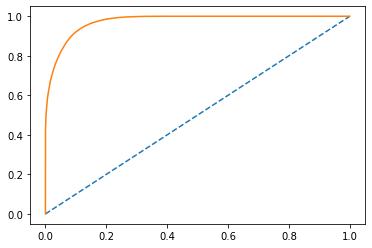

In [452]:
y_prob_tr5 = xgb_t.predict_proba(Xnew)[:,1]
auc_tr5 = roc_auc_score(ynew,y_prob_tr5)
fpr_tr5 , tpr_tr5, thr_tr5 = roc_curve(ynew,y_prob_tr5)
print('AUC:',auc_tr5)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr_tr5,tpr_tr5)
plt.show()

AUC: 0.8401014054564176


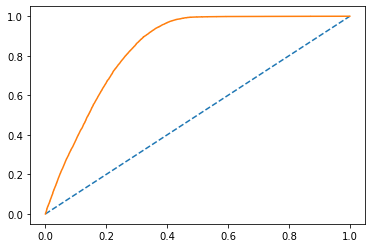

In [453]:
y_prob_te5 = xgb_t.predict_proba(x_test)[:,1]
auc_te5 = roc_auc_score(y_test,y_prob_te5)
fpr_te5 , tpr_te5, thr_te5 = roc_curve(y_test,y_prob_te5)
print('AUC:',auc_te5)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr_te5,tpr_te5)
plt.show()

In [454]:
optimal_tr5 = np.argmax(tpr_tr5 - fpr_tr5)
optimal_thresh_tr5 = thr_tr5[optimal_tr5]
print('Best threshold train:',optimal_thresh_tr5)
optimal_te5 = np.argmax(tpr_te5 - fpr_te5)
optimal_thresh_te5 = thr_te5[optimal_te5]
print('Best threshold test:',optimal_thresh_te5)

Best threshold train: 0.36463955
Best threshold test: 0.07242761


In [455]:
y_train_pr5 = []
for i in range(0,len(y_prob_tr5)):
    if np.array(y_prob_tr5)[i] > 0.00001:
        a=1
    else:
        a=0
    y_train_pr5.append(a)
# Testing prediction
y_test_pr5 = []
for i in range(0,len(y_prob_te5)):
    if np.array(y_prob_te5)[i]> 0.1:
        b=1
    else:
        b=0
    y_test_pr5.append(b)

In [511]:
print('Balanced XGBoost Classifier Threshold Tuned:\n')
print(classification_report(y_test, y_test_pr5))
print('Training Accuracy: ', round(xgb_t.score(Xnew,ynew),5),'\tTesting Accuracy: ',round(xgb_t.score(x_test,y_test),5))
print('Training Precision:', round(precision_score(ynew,y_train_pr5),5),'\tTesting Precision:',round(precision_score(y_test,y_test_pr5),5))
print('Training Recall:   ', round(recall_score(ynew,y_train_pr5),5),'\tTesting Recall:   ',round(recall_score(y_test,y_test_pr5),5))

Balanced XGBoost Classifier Threshold Tuned:

              precision    recall  f1-score   support

           0       0.98      0.66      0.79    100195
           1       0.28      0.91      0.42     14138

    accuracy                           0.69    114333
   macro avg       0.63      0.79      0.61    114333
weighted avg       0.89      0.69      0.74    114333

Training Accuracy:  0.91366 	Testing Accuracy:  0.82915
Training Precision: 0.29442 	Testing Precision: 0.2751
Training Recall:    1.0 	Testing Recall:    0.91406


In [522]:
print(round(f1_score(ynew,y_train_pr5),4))
print(round(f1_score(y_test,y_test_pr5),4))

0.4549
0.4229


In [448]:
pred_tr = xgb_t.predict_proba(Xnew)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(ynew)):
        if np.array(pred_tr[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,6),round(precision_score(ynew,custom_cutoff_data),4))

0.0 0.2815
0.1 0.569
0.2 0.6397
0.3 0.7034
0.4 0.7611
0.5 0.8307
0.6 0.9079
0.7 0.9663
0.8 0.993
0.9 0.9995


In [443]:
pred_tr = xgb_t.predict_proba(Xnew)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(ynew)):
        if np.array(pred_tr[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,6),round(recall_score(ynew,custom_cutoff_data),4))

0.0 1.0
0.1 0.9915
0.2 0.9697
0.3 0.9355
0.4 0.8849
0.5 0.7899
0.6 0.6442
0.7 0.5024
0.8 0.391
0.9 0.3395


In [444]:
pred_te = xgb_t.predict_proba(x_test)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(y_test)):
        if np.array(pred_te[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,3),round(precision_score(y_test,custom_cutoff_data),4))

0.0 0.1237
0.1 0.2748
0.2 0.2988
0.3 0.3166
0.4 0.3304
0.5 0.3447
0.6 0.3656
0.7 0.3807
0.8 0.4091
0.9 0.479


In [445]:
pred_te = xgb_t.predict_proba(x_test)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(y_test)):
        if np.array(pred_te[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,3),round(recall_score(y_test,custom_cutoff_data),4))

0.0 1.0
0.1 0.9147
0.2 0.808
0.3 0.6954
0.4 0.573
0.5 0.4146
0.6 0.245
0.7 0.1116
0.8 0.0339
0.9 0.004


### Cat Boost

In [193]:
from catboost import CatBoostClassifier

In [194]:
cb= CatBoostClassifier(silent=True)
cb= cb.fit(Xnew,ynew)
y_pred_cb= cb.predict(x_test)
print(classification_report(y_test,y_pred_cb))
print('Training Accuracy', cb.score(Xnew,ynew),'\tTesting Accuracy', cb.score(x_test,y_test))
print('Training Precision', precision_score(ynew,cb.predict(Xnew)),'\tTesting Precision',precision_score(y_test,y_pred_cb))
print('Training Recall', recall_score(ynew,cb.predict(Xnew)),'\tTesting Recall',recall_score(y_test,y_pred_cb))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90    100195
           1       0.36      0.45      0.40     14138

    accuracy                           0.83    114333
   macro avg       0.64      0.67      0.65    114333
weighted avg       0.85      0.83      0.84    114333

Training Accuracy 0.8576951789201225 	Testing Accuracy 0.8340111778751541
Training Precision 0.7612532343894938 	Testing Precision 0.3611111111111111
Training Recall 0.7213605819830448 	Testing Recall 0.44504173150374876


In [196]:
from sklearn.model_selection import RandomizedSearchCV
g= {'depth': [10,14,16,18,20],
    'iterations': [50,80,120,150,200,300]
    }
gs= RandomizedSearchCV(CatBoostClassifier(),
                      param_distributions=g,
                      n_iter=10,
                      scoring=precision_score,
                      cv=3,
                      n_jobs=-1,
                      verbose=False)
gs.fit(Xnew,ynew)
print('Best parameters for Decision Tree Classifier: ', gs.best_params_, '\n')

Learning rate set to 0.358323
0:	learn: 0.4173141	total: 213ms	remaining: 1m 3s
1:	learn: 0.3770926	total: 4.79s	remaining: 11m 53s
2:	learn: 0.3624959	total: 9.97s	remaining: 16m 26s
3:	learn: 0.3570728	total: 10.1s	remaining: 12m 30s
4:	learn: 0.3508395	total: 15.5s	remaining: 15m 16s
5:	learn: 0.3448018	total: 20.4s	remaining: 16m 38s
6:	learn: 0.3408130	total: 25.1s	remaining: 17m 29s
7:	learn: 0.3372374	total: 29.8s	remaining: 18m 9s
8:	learn: 0.3361672	total: 30s	remaining: 16m 8s
9:	learn: 0.3315359	total: 35s	remaining: 16m 53s
10:	learn: 0.3289232	total: 39.8s	remaining: 17m 25s
11:	learn: 0.3258246	total: 44.9s	remaining: 17m 57s
12:	learn: 0.3230912	total: 45.1s	remaining: 16m 35s
13:	learn: 0.3227803	total: 45.3s	remaining: 15m 24s
14:	learn: 0.3197718	total: 50s	remaining: 15m 49s
15:	learn: 0.3172203	total: 54.7s	remaining: 16m 11s
16:	learn: 0.3136244	total: 59.7s	remaining: 16m 33s
17:	learn: 0.3095325	total: 1m 4s	remaining: 16m 49s
18:	learn: 0.3075916	total: 1m 9s	re

In [512]:
cb_t= CatBoostClassifier(silent=True, learning_rate=0.01, iterations=300 ,depth=16)
cb_t= cb_t.fit(Xnew,ynew)
y_pred_cb_t= cb_t.predict(x_test)
print('Balanced Cat Boost Model Tuned:\n')
print(classification_report(y_test,y_pred_cb_t))
print('Training Accuracy: ', round(cb_t.score(Xnew,ynew),4),'\tTesting Accuracy: ',round(cb_t.score(x_test,y_test),4))
print('Training Precision:', round(precision_score(ynew,cb_t.predict(Xnew)),4),'\tTesting Precision:',round(precision_score(y_test,y_pred_cb_t),4))
print('Training Recall:   ', round(recall_score(ynew,cb_t.predict(Xnew)),4),'\tTesting Recall:   ',round(recall_score(y_test,y_pred_cb_t),4))

Balanced Cat Boost Model Tuned:

              precision    recall  f1-score   support

           0       0.95      0.82      0.88    100195
           1       0.34      0.66      0.45     14138

    accuracy                           0.80    114333
   macro avg       0.64      0.74      0.67    114333
weighted avg       0.87      0.80      0.83    114333

Training Accuracy:  0.8287 	Testing Accuracy:  0.8017
Training Precision: 0.6663 	Testing Precision: 0.3439
Training Recall:    0.784 	Testing Recall:    0.6647


In [464]:
pred_tr = cb_t.predict_proba(Xnew)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(ynew)):
        if np.array(pred_tr[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,6),round(precision_score(ynew,custom_cutoff_data),4))

0.0 0.2815
0.1 0.5044
0.2 0.5348
0.3 0.5736
0.4 0.6186
0.5 0.6647
0.6 0.7717
0.7 0.9516
0.8 0.9997
0.9 1.0


In [458]:
pred_tr = cb_t.predict_proba(Xnew)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(ynew)):
        if np.array(pred_tr[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,6),round(recall_score(ynew,custom_cutoff_data),4))

0.0 1.0
0.1 0.9956
0.2 0.9814
0.3 0.9449
0.4 0.891
0.5 0.7861
0.6 0.5111
0.7 0.1822
0.8 0.0362
0.9 0.0006


In [461]:
pred_te = cb_t.predict_proba(x_test)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(y_test)):
        if np.array(pred_te[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,3),round(precision_score(y_test,custom_cutoff_data),4))

0.0 0.1237
0.1 0.2491
0.2 0.269
0.3 0.2935
0.4 0.3182
0.5 0.3431
0.6 0.3912
0.7 0.4783
0.8 0.25
0.9 0.0


In [462]:
pred_te = cb_t.predict_proba(x_test)[:,1]
for j in np.arange(0,1,0.1):
    custom_prob=j
    custom_cutoff_data=[]
    for i in range(0,len(y_test)):
        if np.array(pred_te[i]) > custom_prob:
            a=1
        else:
            a=0
        custom_cutoff_data.append(a)
    print(round(custom_prob,3),round(recall_score(y_test,custom_cutoff_data),4))

0.0 1.0
0.1 0.9849
0.2 0.9624
0.3 0.9011
0.4 0.8081
0.5 0.6683
0.6 0.3398
0.7 0.0351
0.8 0.0001
0.9 0.0


AUC: 0.9126697592924208


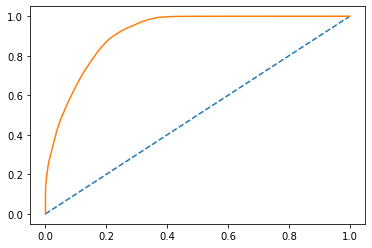

In [466]:
y_prob_tr6 = cb_t.predict_proba(Xnew)[:,1]
auc_tr6 = roc_auc_score(ynew,y_prob_tr6)
fpr_tr6 , tpr_tr6, thr_tr6 = roc_curve(ynew,y_prob_tr6)
print('AUC:',auc_tr6)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr_tr6,tpr_tr6)
plt.show()

AUC: 0.8562377345644376


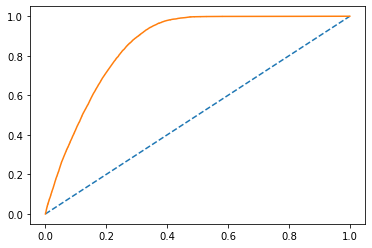

In [468]:
y_prob_te6 = cb_t.predict_proba(x_test)[:,1]
auc_te6 = roc_auc_score(y_test,y_prob_te6)
fpr_te6 , tpr_te6, thr_te6 = roc_curve(y_test,y_prob_te6)
print('AUC:',auc_te6)
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr_te6,tpr_te6)
plt.show()

In [469]:
y_train_pr6 = []
for i in range(0,len(y_prob_tr6)):
    if np.array(y_prob_tr6)[i] > 0.00001:
        a=1
    else:
        a=0
    y_train_pr6.append(a)
# Testing prediction
y_test_pr6 = []
for i in range(0,len(y_prob_te6)):
    if np.array(y_prob_te6)[i]> 0.2:
        b=1
    else:
        b=0
    y_test_pr6.append(b)

In [513]:
print('Balanced Cat Boost Threshold Tuned:\n')
print(classification_report(y_test, y_test_pr6))
print('Training Accuracy: ', round(cb_t.score(Xnew,ynew),4),'\tTesting Accuracy: ',round(cb_t.score(x_test,y_test),4))
print('Training Precision:', round(precision_score(ynew,y_train_pr6),4),'\tTesting Precision:',round(precision_score(y_test,y_test_pr6),4))
print('Training Recall:   ', round(recall_score(ynew,y_train_pr6),4),'\tTesting Recall:   ',round(recall_score(y_test,y_test_pr6),4))

Balanced Cat Boost Threshold Tuned:

              precision    recall  f1-score   support

           0       0.99      0.63      0.77    100195
           1       0.27      0.96      0.42     14138

    accuracy                           0.67    114333
   macro avg       0.63      0.80      0.60    114333
weighted avg       0.90      0.67      0.73    114333

Training Accuracy:  0.8287 	Testing Accuracy:  0.8017
Training Precision: 0.2815 	Testing Precision: 0.269
Training Recall:    1.0 	Testing Recall:    0.9624


In [523]:
print(round(f1_score(ynew,y_train_pr6),4))
print(round(f1_score(y_test,y_test_pr6),4))

0.4393
0.4205


In [525]:
important_features = pd.DataFrame({'Features': Xnew.columns, 
                                   'Importance': cb_t.feature_importances_})

# print the dataframe
important_features.sort_values(by='Importance', ascending=False, inplace=True)
important_features

,Features,Importance
7,Previously_Insured_1,35.745004
1,Age,26.463712
3,Vehicle_Damage,9.838991
2,Region_Code,7.672974
4,Annual_Premium,7.636899
5,Policy_Sales_Channel,7.369432
0,Gender,3.953082
8,New_vehicles,0.802547
9,Old_vehicles,0.409460
6,Driving_License_1,0.107900


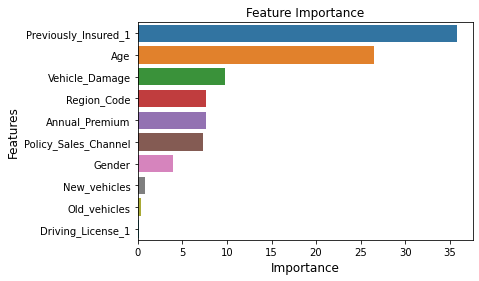

In [528]:
sns.barplot(x = 'Importance', y = 'Features', data = important_features)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Feature Importance', fontsize = 12)
plt.xlabel('Importance', fontsize = 12)
plt.ylabel('Features', fontsize = 12)
plt.show()

In [530]:
cm = confusion_matrix(y_test,y_test_pr6)
pd.DataFrame(cm, columns={'Predicted 0':cm[0][0],'Predicted 1':cm[0][1]},index=['Actual 0','Actual 1'])

,Predicted 0,Predicted 1
Actual 0,63221,36974
Actual 1,531,13607


In [531]:
cm

array([[63221, 36974],
       [  531, 13607]], dtype=int64)